# Setup

## Imports

In [347]:
import os

In [348]:
import numpy as np
import pandas as pd

In [349]:
import matplotlib
from matplotlib import patheffects
import matplotlib.pyplot as plt
import seaborn as sns

## Parameters

In [350]:
keys = [
    'Bacon2019',
    'hafenLowredshiftLymanLimit2017',
    'Imeletal2022',
    'Ololube2012',
    'Torres2013',
    'West2003',
    'Miele2022',
    'ForeroOrtega2021',
    'Andre2018',
]
key = keys[1]
librarian = 'S2'
vectorizer = 'SciBERT'
split_at_median = False
quantile = 0.25

# I'm being dumb here
metric_quantile = quantile
metric_percent = int(100 * metric_quantile)

In [351]:
# TODO: we can simplify all this param sweeping logic via analysis_data/all_data.csv
key_to_field = {
    'Bacon2019': 'Philosophy',
    'hafenLowredshiftLymanLimit2017': 'Physics',
    'Imeletal2022': 'Linguistics',
    'Ololube2012': 'Education',
    'Torres2013': 'Medicine',
    'West2003': 'Economics',
    'Miele2022': 'Materials Science',
    'ForeroOrtega2021': 'Geology',
    'Andre2018': 'Mathematics',
}

## Process Parameters

In [352]:
directory = os.path.join(
    '../../outputs',
    f'librarian={librarian}',
    f'vectorizer={vectorizer}',
)

# Data Preprocessing

In [353]:
dfs = []
for key in keys:
    fp = os.path.join(directory, f'center={key}/all_data.csv')
    df = pd.read_csv(fp)

    # Density categorization
    if split_at_median:
        med_density = df['density'].median()
        df['density_cat'] = (df['density'] > med_density).astype('category')
        df['density_cat'] = df['density_cat'].cat.rename_categories({
            True: 'upper',
            False: 'lower',
        })
    else:
        upper_quantile = df['density'].quantile(1 - metric_quantile)
        lower_quantile = df['density'].quantile(metric_quantile)
        df['density_cat'] = 'center'
        df.loc[df['density'] < lower_quantile, 'density_cat'] = f'lower {metric_percent}%'
        df.loc[df['density'] > upper_quantile, 'density_cat'] = f'upper {metric_percent}%'
        df = df.loc[df['density_cat'] != 'center']
        df['density_cat'] = df['density_cat'].astype('category')

    # Center category
    df['center'] = key
    df['field'] = key_to_field[key]

    dfs.append(df)

In [354]:
# Combine
df = pd.concat(dfs)
df.head()

,density,edginess,references,citations_per_year,is_center,identifier,year,density_cat,center,field
0,28.342346,0.668440,98,1.333333,False,bf1b0fd642fa828fb903abd01396bd84e7949955,2014,lower 25%,Bacon2019,Philosophy
1,38.521431,0.643562,9,0.705882,False,fe5e0550adcdcc467f1a34829a2dd5212c3cafef,2003,upper 25%,Bacon2019,Philosophy
2,28.897468,0.701957,0,1.615385,False,21493dbd22b97c4df50dab35a31f03a9bfc93c56,2007,lower 25%,Bacon2019,Philosophy
4,38.961657,0.721525,37,0.000000,False,fef71652063840b31932f55821f1f553577f3487,2019,upper 25%,Bacon2019,Philosophy
5,27.985438,0.685752,49,13.333333,False,a443eb467d1433b8c5fce80d9adfe9cb45839021,2011,lower 25%,Bacon2019,Philosophy


In [355]:
# Make a combined category
df['label'] = (
    df['center'].astype(str) + '_' + df['density_cat'].astype(str)
).astype('category')

In [356]:
# Make a log scale version
df['log_cpy'] = np.log10(df['citations_per_year'])
df['log_cpy'] = df['log_cpy'].replace(-np.inf, np.nan)

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [357]:
# why are there duplicates?
# df = df[~df.index.duplicated()]
print(len(df[df.index.duplicated()]))
df = df.reset_index()
print(len(df[df.index.duplicated()]))

38952
0


# Visualization

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73874/3451272578.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_center_by_density = df_center.groupby('density_cat')


Median fraction change: 1.29
Median std fraction change: 0.71



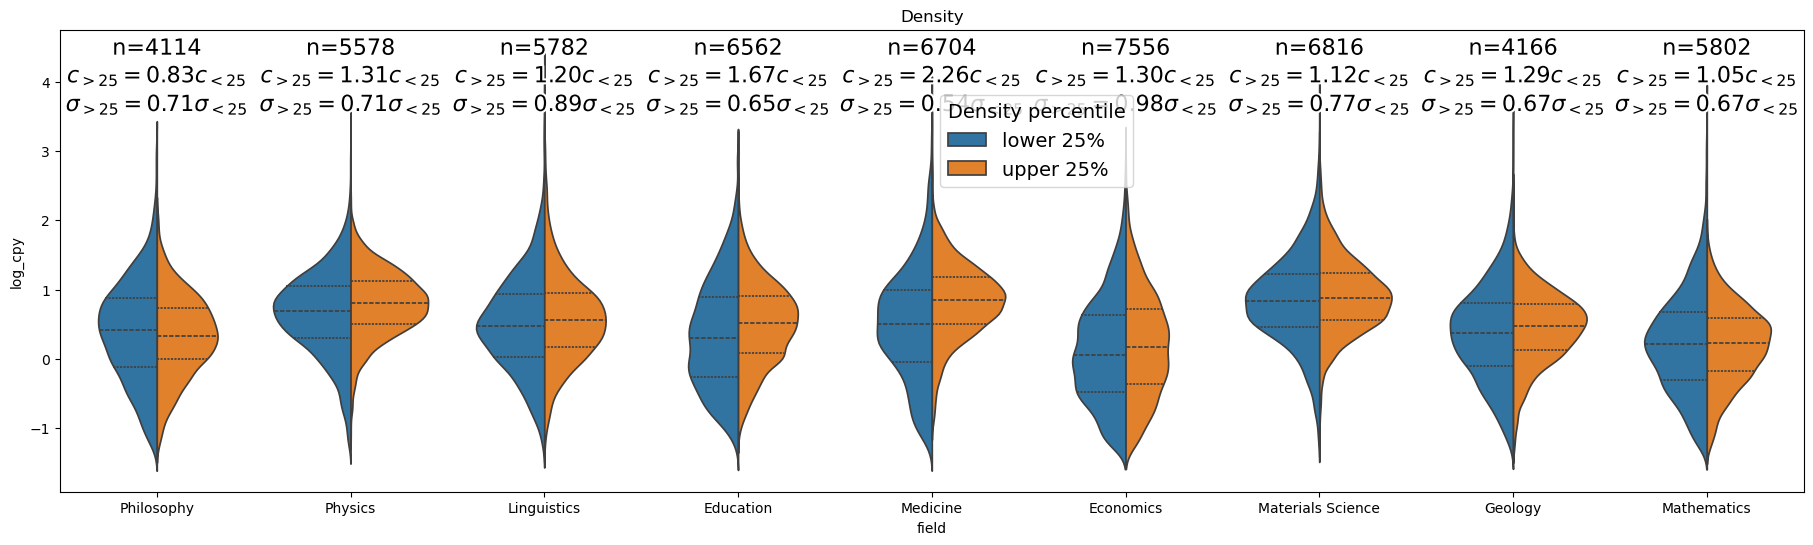

In [358]:
import matplotlib.transforms


fig = plt.figure(figsize=(len(keys) * 2.5, 6))
ax = plt.gca()
ax.set_title("Density")

sns.violinplot(
    ax=ax,
    data=df,
    # x='center',
    x='field',
    y='log_cpy',
    # y='citations_per_year',
    hue='density_cat',
    # palette='mako',
    split=True,
    inner='quart',
    dodge=True,
    gap=0,
)

df_by_center = df.groupby('center')
fraction_changes = []
fraction_std_changes = []
for i, key in enumerate(keys):

    # Get the group
    df_center = df_by_center.get_group(key)
    n = df_center.shape[0]

    # Median change
    df_center_by_density = df_center.groupby('density_cat')
    med_cpy = 10.**df_center_by_density['log_cpy'].median()
    fraction_change = med_cpy[f'upper {metric_percent}%'] / med_cpy[f'lower {metric_percent}%']
    fraction_changes.append(fraction_change)
    median_change_str = (
        fr'$c_{{>{metric_percent}}} = '
        f'{fraction_change:.2f}'
        fr'c_{{<{metric_percent}}}$'
    )

    # Median change in width
    std_cpy = 10.**df_center_by_density['log_cpy'].std()
    fraction_std_change =  std_cpy[f'upper {metric_percent}%'] / std_cpy[f'lower {metric_percent}%']
    fraction_std_changes.append(fraction_std_change)
    std_change_str = (
        fr'$\sigma_{{>{metric_percent}}} = '
        f'{fraction_std_change:.2f}'
        fr'\sigma_{{<{metric_percent}}}$'
    )

    text = ax.annotate(
        text=f'n={n}\n' + median_change_str + '\n' + std_change_str,
        xy=(i, 1),
        xycoords=matplotlib.transforms.blended_transform_factory(
            ax.transData,
            ax.transAxes,
        ),
        xytext=(0, -5),
        textcoords='offset points',
        ha='center',
        va='top',
        fontsize=14,
    )
    text.set_path_effects([
        patheffects.Stroke(linewidth=3, foreground='w'),
        patheffects.Normal()
    ])

ax.legend(prop=dict(size=14))
legend = ax.get_legend()
legend.set_title('Density percentile', prop=dict(size=14))
legend.set_loc('upper center')
legend.set_bbox_to_anchor((0.56, 0.88))
legend.set_alignment('left')


# log scale if doing raw cpy
# NOTE: this didn't work, the distribution looked weird
# ax.set_yscale( 'log' )
# from matplotlib.ticker import ScalarFormatter
# ax.yaxis.set_major_formatter(ScalarFormatter())
# ax.yaxis.get_major_formatter().set_scientific(False)

print(
    f'Median fraction change: {np.median(fraction_changes):.2f}\n'
    f'Median std fraction change: {np.median(fraction_std_changes):.2f}\n'
)

## Edginess?

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73874/1962964884.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_center_by_edginess = df_center.groupby('edginess_cat')


Median fraction change: 0.90
Median std fraction change: 1.19



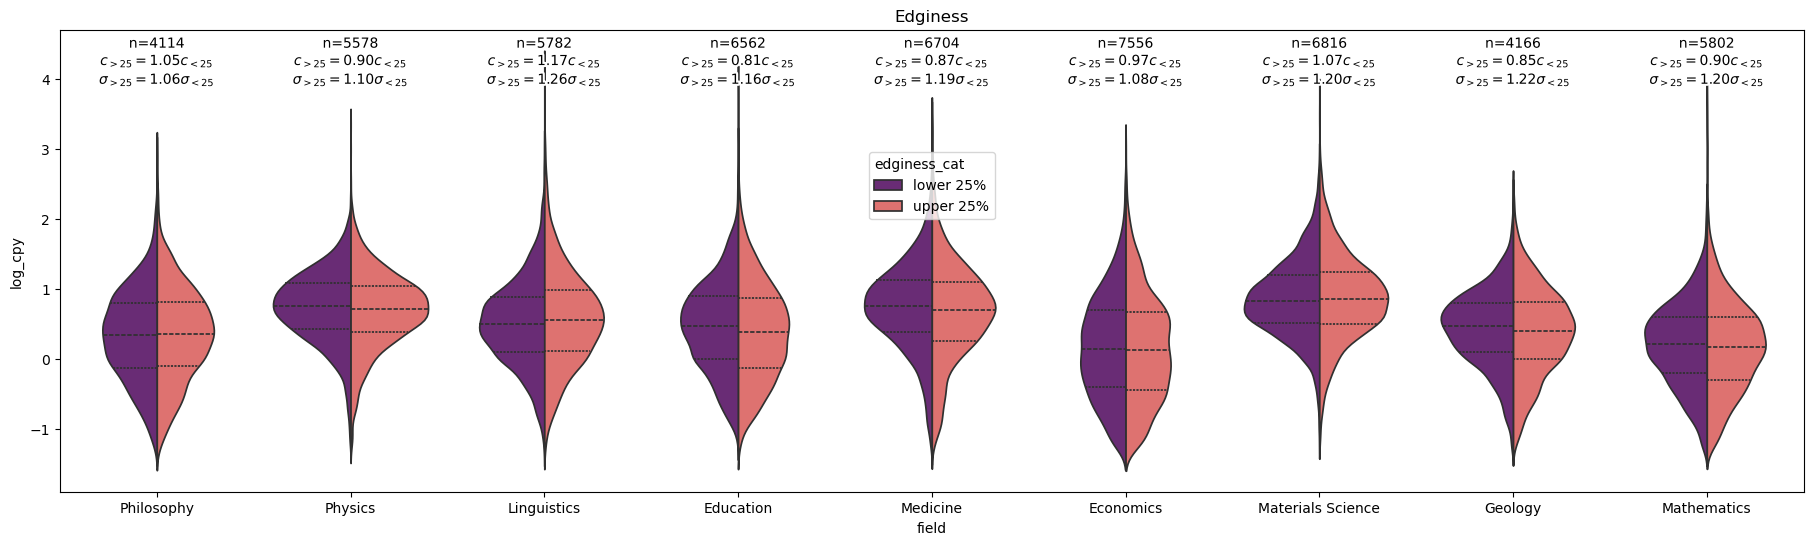

In [359]:
dfs = []
for key in keys:
    fp = os.path.join(directory, f'center={key}/all_data.csv')
    df = pd.read_csv(fp)

    # Density categorization
    if split_at_median:
        med_edginess = df['edginess'].median()
        df['edginess_cat'] = (df['edginess'] > med_edginess).astype('category')
        df['edginess_cat'] = df['edginess_cat'].cat.rename_categories({
            True: 'upper',
            False: 'lower',
        })
    else:
        upper_quantile = df['edginess'].quantile(1 - metric_quantile)
        lower_quantile = df['edginess'].quantile(metric_quantile)
        df['edginess_cat'] = 'center'
        df.loc[df['edginess'] < lower_quantile, 'edginess_cat'] = f'lower {metric_percent}%'
        df.loc[df['edginess'] > upper_quantile, 'edginess_cat'] = f'upper {metric_percent}%'
        df = df.loc[df['edginess_cat'] != 'center']
        df['edginess_cat'] = df['edginess_cat'].astype('category')

    # Center category
    df['center'] = key
    df['field'] = key_to_field[key]

    dfs.append(df)

# Combine
df = pd.concat(dfs)    


# Make a combined category
df['label'] = (
    df['center'].astype(str) + '_' + df['edginess_cat'].astype(str)
).astype('category')


# Make a log scale version
df['log_cpy'] = np.log10(df['citations_per_year'])
df['log_cpy'] = df['log_cpy'].replace(-np.inf, np.nan)

df = df.reset_index()


fig = plt.figure(figsize=(len(keys) * 2.5, 6))
ax = plt.gca()
ax.set_title("Edginess")


sns.violinplot(
    ax=ax,
    data=df,
    # x='center',
    x='field',
    y='log_cpy',
    hue='edginess_cat',
    palette="magma",
    split=True,
    inner='quart',
    dodge=True,
    gap=0,
)



df_by_center = df.groupby('center')
fraction_changes = []
fraction_std_changes = []
for i, key in enumerate(keys):

    # Get the group
    df_center = df_by_center.get_group(key)
    n = df_center.shape[0]

    # Median change
    df_center_by_edginess = df_center.groupby('edginess_cat')
    med_cpy = 10.**df_center_by_edginess['log_cpy'].median()

    fraction_change = med_cpy[f'upper {metric_percent}%'] / med_cpy[f'lower {metric_percent}%']
    fraction_changes.append(fraction_change)
    median_change_str = (
        fr'$c_{{>{metric_percent}}} = '
        f'{fraction_change:.2f}'
        fr'c_{{<{metric_percent}}}$'
    )

    # Median change in width
    std_cpy = 10.**df_center_by_edginess['log_cpy'].std()
    fraction_std_change =  std_cpy[f'upper {metric_percent}%'] / std_cpy[f'lower {metric_percent}%']
    fraction_std_changes.append(fraction_std_change)
    std_change_str = (
        fr'$\sigma_{{>{metric_percent}}} = '
        f'{fraction_std_change:.2f}'
        fr'\sigma_{{<{metric_percent}}}$'
    )

    text = ax.annotate(
        text=f'n={n}\n' + median_change_str + '\n' + std_change_str,
        xy=(i, 1),
        xycoords=matplotlib.transforms.blended_transform_factory(
            ax.transData,
            ax.transAxes,
        ),
        xytext=(0, -5),
        textcoords='offset points',
        ha='center',
        va='top',
    )
    text.set_path_effects([
        patheffects.Stroke(linewidth=3, foreground='w'),
        patheffects.Normal()
    ])

legend = ax.get_legend()
legend.set_loc('upper center')
legend.set_bbox_to_anchor((0.5, 0.75))
legend.set_alignment('left')

print(
    f'Median fraction change: {np.median(fraction_changes):.2f}\n'
    f'Median std fraction change: {np.median(fraction_std_changes):.2f}\n'
)